In [163]:
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns

In [164]:
!pip install kaggle

In [165]:
# moves the uploaded kaggle.json file to this newly created .kaggle directory.
# This is necessary because the Kaggle API expects to find the kaggle.json file in the .kaggle directory to authenticate the user and allow access to Kaggle's resources.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


mv: cannot stat 'kaggle.json': No such file or directory


In [166]:
# Download the dataset using the Kaggle API command
!kaggle datasets download -d serenaraju/yawn-eye-dataset-new

yawn-eye-dataset-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [167]:
# Extract the downloaded zip file
import zipfile

with zipfile.ZipFile("yawn-eye-dataset-new.zip", "r") as zip_ref:
    zip_ref.extractall("data/yawn-eye-dataset/")

In [209]:
# Define transformations for augmentation
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    torchvision.transforms.Resize((256,256)) # Resize the image to (256,256)
])


# Define batch size
batch_size = 64

# Define training dataset with augmentation
dataset_augmented = torchvision.datasets.ImageFolder(
    root='/content/data/yawn-eye-dataset/dataset_new/train',
    transform=transform_augmented
)

# Define training dataset and create DataLoader
test_dataset = torchvision.datasets.ImageFolder(
    root='/content/data/yawn-eye-dataset/dataset_new/test',
    transform=transform_augmented
)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset_augmented))
print("Length of combined dataset:", len(dataset_augmented))
val_size = len(dataset_augmented) - train_size
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Length of combined dataset: 2467


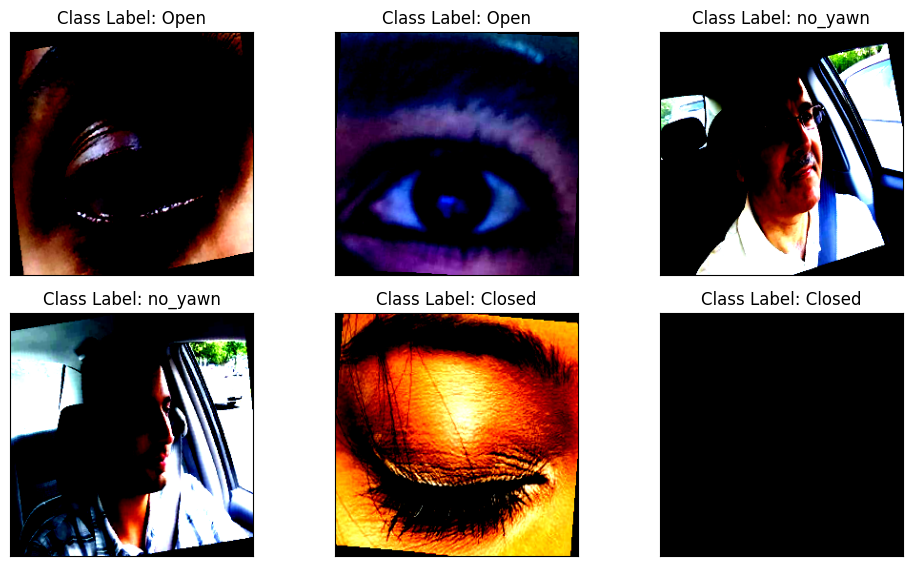

In [210]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names
class_names = dataset_augmented.classes

# Display a subset of images from the training dataset along with their ground truth labels
fig = plt.figure(figsize= (10,6))
for i in range(6):
    image, label = next(iter(train_loader))
    image = np.transpose(image[0].squeeze().numpy(), (1, 2, 0))
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(image)
    plt.title("Class Label: {}".format(class_names[label[0].item()]))
    plt.xticks([])
    plt.yticks([])
fig.show()

In [211]:
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Global average pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # First fully connected layer
        self.fc1 = nn.Linear(128, 256)
        # Second fully connected layer (output layer)
        self.fc2 = nn.Linear(256, num_classes)
        # Dropout layer with probability 0.5
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # First convolutional layer with ReLU activation
        x = F.relu(self.conv1(x))
        # Max pooling
        x = self.pool(x)
        # Dropout after the first pooling layer
        x = self.dropout(x)
        # Second convolutional layer with ReLU activation
        x = F.relu(self.conv2(x))
        # Max pooling
        x = self.pool(x)
        # Dropout after the second pooling layer
        x = self.dropout(x)
        # Third convolutional layer with ReLU activation
        x = F.relu(self.conv3(x))
        # Max pooling
        x = self.pool(x)
        # Dropout after the third pooling layer
        x = self.dropout(x)
        # Global average pooling
        x = self.global_avg_pool(x)
        # Flatten the tensor
        x = torch.flatten(x, 1)
        # First fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Dropout before the final fully connected layer
        x = self.dropout(x)
        # Second fully connected layer (output layer)
        x = self.fc2(x)
        return x

In [212]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
model = MyCNN(num_classes=4).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)  # Append training loss for this epoch

    # Evaluation loop
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)  # Append validation loss for this epoch
    # Display Training Loss and Validation Loss in each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch [1/25], Loss: 1.1643, Validation Loss: 0.8876
Epoch [2/25], Loss: 0.8168, Validation Loss: 0.7849
Epoch [3/25], Loss: 0.7698, Validation Loss: 0.7527
Epoch [4/25], Loss: 0.7292, Validation Loss: 0.7199
Epoch [5/25], Loss: 0.7264, Validation Loss: 0.7125
Epoch [6/25], Loss: 0.7074, Validation Loss: 0.6990
Epoch [7/25], Loss: 0.7007, Validation Loss: 0.7091
Epoch [8/25], Loss: 0.7063, Validation Loss: 0.7040
Epoch [9/25], Loss: 0.6949, Validation Loss: 0.6992
Epoch [10/25], Loss: 0.6912, Validation Loss: 0.6932
Epoch [11/25], Loss: 0.6902, Validation Loss: 0.6934
Epoch [12/25], Loss: 0.6934, Validation Loss: 0.7027
Epoch [13/25], Loss: 0.6860, Validation Loss: 0.6804
Epoch [14/25], Loss: 0.6830, Validation Loss: 0.6822
Epoch [15/25], Loss: 0.6897, Validation Loss: 0.6908
Epoch [16/25], Loss: 0.6863, Validation Loss: 0.6853
Epoch [17/25], Loss: 0.6960, Validation Loss: 0.6789
Epoch [18/25], Loss: 0.6852, Validation Loss: 0.6859
Epoch [19/25], Loss: 0.6811, Validation Loss: 0.7243
Ep

In [172]:
# Save the model
torch.save(model.state_dict(), 'CNN_model.pth')

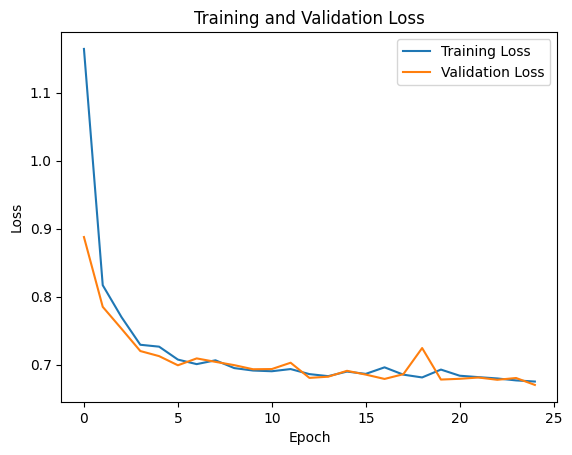

In [213]:
# Plotting the training and validation loss graph
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


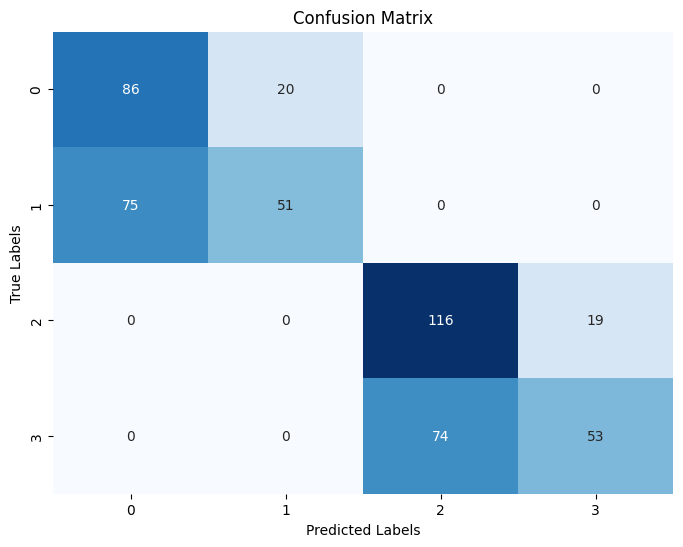

In [216]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [217]:
# Print the model architecture
model

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [218]:
# Create data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize lists to store predictions and true labels
test_preds = []
test_labels = []

# Put model in evaluation mode
model.eval()

# Iterate over the test loader
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Perform inference
        outputs = model(images)

        # Get predicted labels
        _, preds = torch.max(outputs, 1)

        # Store predictions and true labels
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, recall, and F1 score
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
test_accuracy = accuracy_score(test_labels, test_preds)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f"Test Accuracy: {test_accuracy:.4f}")

Precision: 0.6498
Recall: 0.6232
F1 Score: 0.6021
Test Accuracy: 0.6351


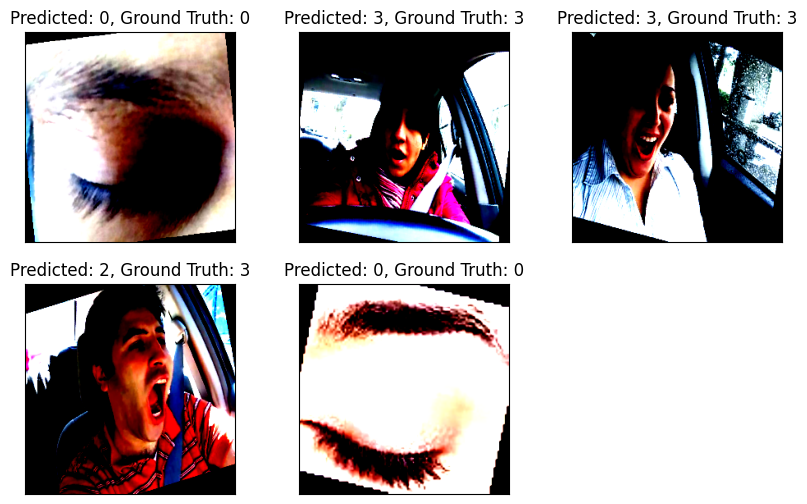

In [219]:
# Visualize the prediction for a few test samples
num_samples_to_predict = 5

fig = plt.figure(figsize= (10,6))
for i in range(num_samples_to_predict):
    plt.subplot(2,3,i+1)
    sample_index = np.random.randint(len(test_dataset))
    sample_image, sample_label = test_dataset[sample_index]
    sample_image = sample_image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(sample_image)
        _, predicted = torch.max(output, 1)

    # Convert tensor to NumPy array and transpose the dimensions
    sample_image_np = np.transpose(sample_image.squeeze().cpu().numpy(), (1, 2, 0))

    # Display the image
    plt.imshow(sample_image_np)
    plt.title(f"Predicted: {predicted.item()}, Ground Truth: {sample_label}")
    plt.xticks([])
    plt.yticks([])
fig.show()

In [178]:
try:
    from torchcam.methods import SmoothGradCAMpp
except ImportError:
    !pip install torchcam
    from torchcam.methods import SmoothGradCAMpp

2


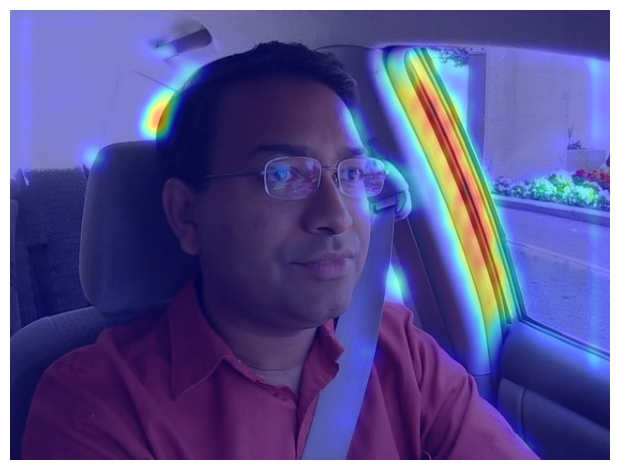

In [220]:
# Understand the decisions made by model by highlights the regions of an input image of class 2(yawn)
# that contribute the most to the model's decision

# Import necessary libraries
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set model to evaluation mode and move it to the device
model.eval().to(device)

# Path to the input image
img_path = "/content/data/yawn-eye-dataset/dataset_new/test/no_yawn/115.jpg"
# Read the image
img = read_image(img_path)
# Apply transformations and move to device
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

# Use SmoothGradCAMpp method to extract CAM
with SmoothGradCAMpp(model, target_layer='conv3') as cam_extractor:
    # Forward pass
    out = model(input_tensor.unsqueeze(0))
    # Predicted class index
    predicted_class = out.squeeze(0).argmax().item()
    print(predicted_class)
    # Retrieve the CAM
    activation_map = cam_extractor(predicted_class, out)

# Overlay the CAM on the input image
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display the result
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()


In [195]:
# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert PIL image to tensor
   # torchvision.transforms.Normalize((0.1307,), (0.3081,)),  # Normalize pixel values
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # Normalize pixel values
    torchvision.transforms.Resize((256,256))  # Resize the image to (256,256)

])

# Define transformations for augmentation
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize pixel values
    torchvision.transforms.Resize((256,256)) # Resize the image to (256,256)
])

# Define batch size
batch_size_train = 64

# Define training dataset without augmentation
dataset_original = torchvision.datasets.ImageFolder(
    root='/content/data/yawn-eye-dataset/dataset_new/train',
    transform=transform
)

# Define training dataset with augmentation
dataset_augmented = torchvision.datasets.ImageFolder(
    root='/content/data/yawn-eye-dataset/dataset_new/train',
    transform=transform_augmented
)

# Combine the original and augmented datasets
combined_dataset = torch.utils.data.ConcatDataset([dataset_original, dataset_augmented])

# Define training dataset and create DataLoader
test_dataset = torchvision.datasets.ImageFolder(
    root='/content/data/yawn-eye-dataset/dataset_new/test',
    transform=transform
)

# Split dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
print("Length of combined dataset:", len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Length of combined dataset: 4934


In [200]:
import torch.nn as nn
from torchvision import models

# Define CNN model with transfer learning
class TransferModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = TransferModel(num_classes=len(dataset_augmented.classes)).to(device)


In [201]:
model_1

TransferModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [202]:
from sklearn.metrics import accuracy_score

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.0001)  # Adding weight decay

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)  # Append training loss for this epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)  # Append training accuracy for this epoch

    # Evaluation loop
    model_1.eval()
    all_preds = []
    all_labels = []
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()
        epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)  # Append validation loss for this epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)  # Append validation accuracy for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/5], Loss: 0.1507, Accuracy: 0.9410, Validation Loss: 1.0909, Validation Accuracy: 0.8105
Epoch [2/5], Loss: 0.0211, Accuracy: 0.9947, Validation Loss: 0.0143, Validation Accuracy: 0.9959
Epoch [3/5], Loss: 0.0234, Accuracy: 0.9932, Validation Loss: 0.0106, Validation Accuracy: 0.9990
Epoch [4/5], Loss: 0.0203, Accuracy: 0.9934, Validation Loss: 0.0505, Validation Accuracy: 0.9848
Epoch [5/5], Loss: 0.0175, Accuracy: 0.9944, Validation Loss: 0.0256, Validation Accuracy: 0.9929


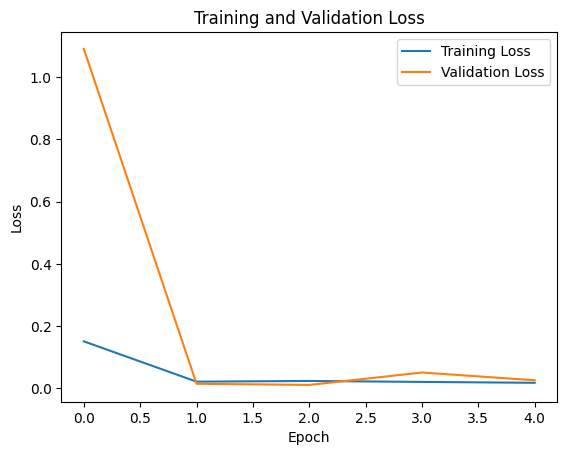

In [203]:
# Plotting the training and validation loss graph
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [204]:
# Create data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize lists to store predictions and true labels
test_preds = []
test_labels = []

# Put model in evaluation mode
model_1.eval()

# Iterate over the test loader
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Perform inference
        outputs = model_1(images)

        # Get predicted labels
        _, preds = torch.max(outputs, 1)

        # Store predictions and true labels
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision and recall
test_accuracy_1 = accuracy_score(test_labels, test_preds)
precision_1 = precision_score(test_labels, test_preds, average='macro')
recall_1 = recall_score(test_labels, test_preds, average='macro')
f1_1 = f1_score(test_labels, test_preds, average='macro')

# Display results
print(f'Precision_ResNet: {precision:.4f}')
print(f'Recall_ResNet: {recall:.4f}')
print(f'F1 Score_ResNet: {f1:.4f}')
print(f"Test Accuracy_ResNet: {test_accuracy_1:.4f}")


Precision_ResNet: 0.6349
Recall_ResNet: 0.6337
F1 Score_ResNet: 0.6311
Test Accuracy_ResNet: 0.9885


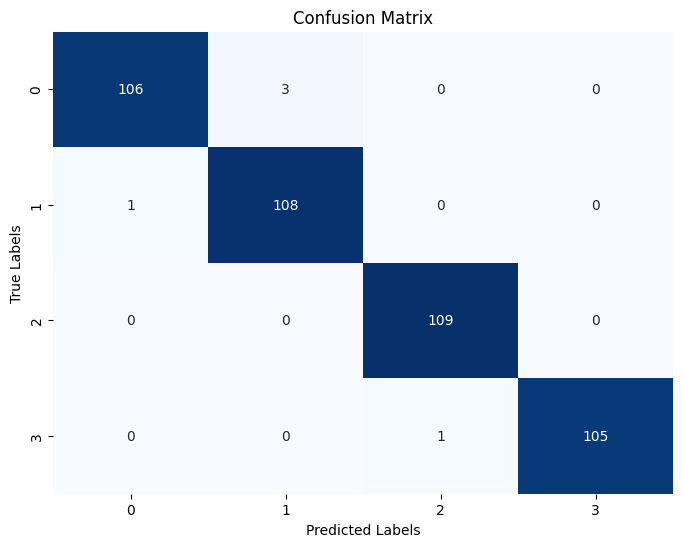

In [205]:
# Confusion matrix
conf_matrix_1 = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

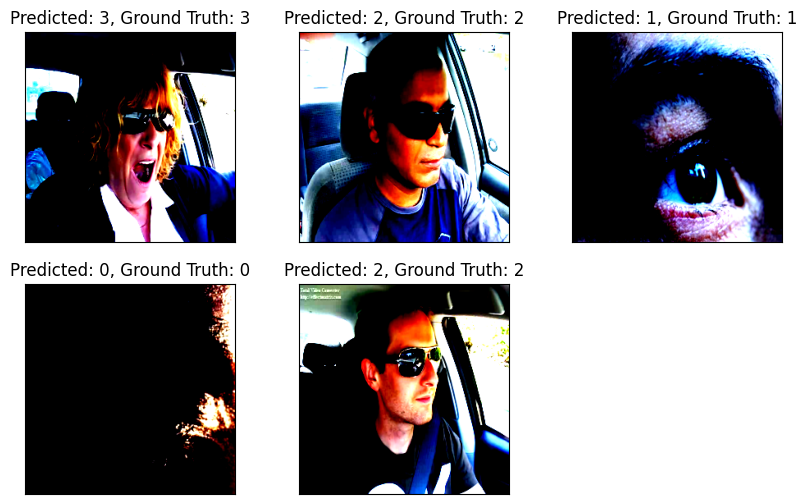

In [206]:
# predict labels for a few test samples
num_samples_to_predict = 5
fig = plt.figure(figsize= (10,6))
for i in range(num_samples_to_predict):
    plt.subplot(2,3,i+1)
    sample_index = np.random.randint(len(test_dataset))
    sample_image, sample_label = test_dataset[sample_index]
    sample_image = sample_image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model_1(sample_image)
        _, predicted = torch.max(output, 1)

    # Convert tensor to NumPy array and transpose the dimensions
    sample_image_np = np.transpose(sample_image.squeeze().cpu().numpy(), (1, 2, 0))

    # Display the image
    plt.imshow(sample_image_np)
    plt.title(f"Predicted: {predicted.item()}, Ground Truth: {sample_label}")
    plt.xticks([])
    plt.yticks([])
fig.show()

3
tensor([[-6.9507, -4.4996, -4.6197, 12.2243]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


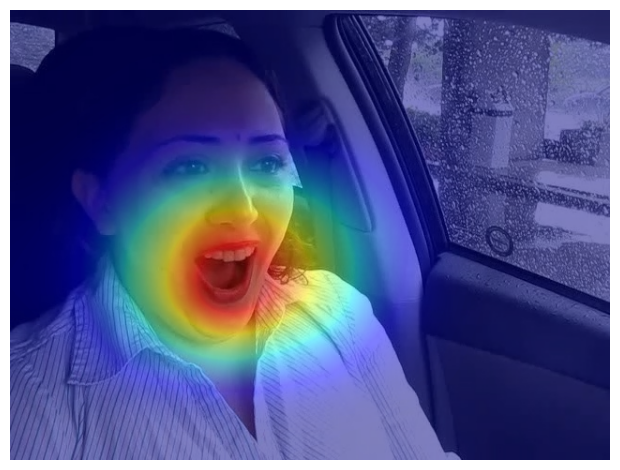

In [207]:

# Understand the decisions made by model by highlights the regions of an input image of class 2(yawn)
# that contribute the most to the model's decision

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is in evaluation mode and move to device
model_1.eval().to(device)

# Get input image
img_path = "/content/data/yawn-eye-dataset/dataset_new/test/yawn/100.jpg"
img = read_image(img_path)
# Apply transformations and move to device
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

# Initialize SmoothGradCAM++ extractor
with SmoothGradCAMpp(model_1) as cam_extractor:
    # Forward pass
    out = model_1(input_tensor.unsqueeze(0))
    # Print predicted class
    print(out.squeeze(0).argmax().item())
    print(out)
    # Extract CAM
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Overlay the CAM on the input image
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display the result
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()


2
tensor([[-10.5782,  -7.6456,  13.5963,  -5.6963]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


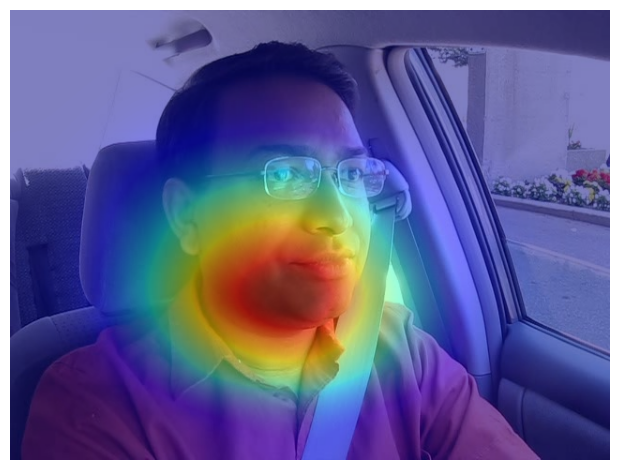

In [208]:

# Understand the decisions made by model by highlights the regions of an input image of class 2(yawn)
# that contribute the most to the model's decision

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is in evaluation mode and move to device
model_1.eval().to(device)

# Get input image
img_path = "/content/data/yawn-eye-dataset/dataset_new/test/no_yawn/115.jpg"
img = read_image(img_path)
# Apply transformations and move to device
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

# Initialize SmoothGradCAM++ extractor
with SmoothGradCAMpp(model_1) as cam_extractor:
    # Forward pass
    out = model_1(input_tensor.unsqueeze(0))
    # Print predicted class
    print(out.squeeze(0).argmax().item())
    print(out)
    # Extract CAM
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Overlay the CAM on the input image
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display the result
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()
